# Introduction

In this notebook, we will try to predict the aggregate review score using the given listings data with just linear regression

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from transformers import pipeline
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] = 16

## Load and prepare data

In [2]:
data_folder_name = "data/seattle"
csv_files = Path(data_folder_name).glob("*.csv")
csv_files = [x for x in csv_files]

In [3]:
dfs = {}
for x in csv_files:
    dfs[str(x.name).split(".")[0]] = pd.read_csv(x)

In [4]:
df_listings = dfs["listings"].copy()

In [5]:
def clean_df_listings(df):
    """
    Preprocess listings dataframe
    Input:
        df: Listings dataframe
    Output:
        df: Cleaned listings dataframe
    """
    
    # Remove columns with all missing values
    df = df.dropna(how="all", axis=1)

    # Fix review columns
    review_scores_cols = [x for x in df.columns if "review_scores" in x]
    # Remove all rows with invalid reviews
    df = df.dropna(how="all", subset=review_scores_cols)
    # Remove rows with no number of reviews
    df = df.dropna(how="any", subset=["number_of_reviews"])
    # Fill missing reviews with 0
    df[review_scores_cols] = df[review_scores_cols].fillna(0)
    # Make all review scores out of 10
    df["review_scores_rating"] = df["review_scores_rating"].apply(lambda x: x/10)
    
    # Fix rate columns
    rate_col_list = ["host_response_rate", "host_acceptance_rate"]
    for col in rate_col_list:
        df[col] = df[col].apply(lambda x: float(str(x).replace("%", ""))/100).fillna(0)
    # Fix price columns
    price_col_list = ["price",
                     "weekly_price",
                     "monthly_price",
                     "security_deposit",
                     "cleaning_fee",
                     "extra_people"]
    for col in price_col_list:
        df[col] = df[col].apply(lambda x: float(str(x).replace("$", "").replace(",", ""))).fillna(0)
    # Fix bool columns
    bool_col_list = ["host_is_superhost", 
                     "host_has_profile_pic", 
                     "host_identity_verified", 
                     "require_guest_profile_picture",
                     "require_guest_phone_verification",
                     "instant_bookable",
                     "is_location_exact"]
    for col in bool_col_list:
        df[col] = df[col].apply(lambda x: x == "t")
    # Get amenities count
    df["num_amenities"] = df["amenities"].apply(lambda x: len(x.split(",")))
    
    # Remove columns with redundant data
    for col in df.columns:
        if len((df[col]).unique())==1:
            df = df.drop(col, axis=1)    
    
    return df

In [6]:
# Clean the data
df_listings = clean_df_listings(df_listings)

In [7]:
def aggregate_review_score(x):
    """
    Aggregate the review score for listings
    Input:
        x: One row from dataframe
    Output:
        out: Aggregated review score
    """
    score = x["review_scores_rating"] + \
            x["review_scores_accuracy"] + \
            x["review_scores_cleanliness"] + \
            x["review_scores_checkin"] + \
            x["review_scores_communication"] + \
            x["review_scores_location"] + \
            x["review_scores_value"]
    score = (score/7)
    
    return score

In [8]:
# Calculate the aggregate review score
df_listings["aggregate_score"] = [aggregate_review_score(x) for _, x in df_listings.iterrows()]

In [9]:
# Get count for each amenity listed and move them into their own columns
amenities_dict = {}
for _, row in df_listings.iterrows():
    amenities = row["amenities"].replace("{", "").replace("}", "").replace("\"", "")
    amenities = amenities.replace("Washer / Dryer", "Washer,Dryer")
    if "," in amenities:
        amenities = amenities.split(",")
    else:
        amenities = [amenities]
    for a in amenities:
        if a != "":
            if a not in amenities_dict:
                amenities_dict[a] = {}
            if row["id"] not in amenities_dict[a]:
                amenities_dict[a][row["id"]] = True
for k in amenities_dict:
    df_listings[k] = df_listings["id"].map(amenities_dict[k]).fillna(False)       
df_listings[amenities_dict.keys()].head()    

,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,Dryer,...,Laptop Friendly Workspace,Suitable for Events,Elevator in Building,Wheelchair Accessible,Gym,Lock on Bedroom Door,Pool,Other pet(s),Smoking Allowed,Doorman
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,True,False,True,True,False,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# Get count for each host verification listed and move them into their own columns
host_verification_dict = {}
for _, row in df_listings.iterrows():
    verifications = row["host_verifications"].replace("[", "").replace("]", "").replace('\'', "")
    if "," in verifications:
        verifications = verifications.split(",")
    else:
        verifications = [verifications]
    for v in verifications:
        if x != "":
            if v not in host_verification_dict:
                host_verification_dict[v] = {}
            if row["id"] not in host_verification_dict[v]:
                host_verification_dict[v][row["id"]] = True
for k in host_verification_dict:
    df_listings[k] = df_listings["id"].map(host_verification_dict[k]).fillna(False)                
df_listings[host_verification_dict.keys()].head()    

,email,phone,reviews,kba,facebook,linkedin,jumio,google,phone,manual_offline,manual_online,sent_id,amex,photographer,weibo,reviews
0,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False
1,True,True,True,False,True,True,True,False,False,False,False,False,False,False,False,False
2,True,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False
4,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False
5,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False


## Let's have a look at the columns and see what we need to drop

In [11]:
# Numeric columns
df_listings.select_dtypes(include=np.number).columns

Index(['id', 'host_id', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'num_amenities', 'aggregate_score'],
      dtype='object')

In [12]:
# Bool columns
df_listings.select_dtypes(include="bool").columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'is_location_exact', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning',
       'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer',
       'Free Parking on Premises', 'Buzzer/Wireless Intercom',
       'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit',
       'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed',
       'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub',
       'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in',
       'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace',
       'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible',
       'Gym', 'Lock on Bedroom Door', 'Pool', 'Other pet(s)',
       'Smoking Allowed', 'Doorman', 'email', ' phone', ' reviews', ' kba',
       ' facebook'

In [13]:
# Categorical columns
df_listings.select_dtypes(include="object").columns

Index(['listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'zipcode', 'smart_location', 'property_type', 'room_type', 'bed_type',
       'amenities', 'calendar_updated', 'first_review', 'last_review',
       'cancellation_policy'],
      dtype='object')

## Ok, now let's prepare the data for the model and run the linear regression

In [14]:
def prepare_for_model_df_listings(df, drop_cols):
    """
    Preprocess listings dataframe
    Input:
        df: Listings dataframe
    Output:
        X: Dataframe with variables for training the model
        y: Dataframe with response output
    """
    
    y = df["aggregate_score"].copy()
    df = df.drop(["aggregate_score"], axis=1).copy()
        
    df = df.drop(drop_cols, axis=1).copy()

    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=np.number).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)    
    
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X,y

In [15]:
def run_linear_regression(X, y, test_size=.3, random_state=42):
    """
    Run linear regression
    Input:
        X: input variables
        y: response variables
    Output:
        train_score: r2 score for training data
        test_score: r2 score for test data
    """
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score 
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    return train_score, test_score

## Initial trial run

In [16]:
drop_cols_numeric = ["id", "host_id", "square_feet"] + [x for x in df_listings.select_dtypes(include=np.number).columns if "review" in x]
drop_cols_object = ["name", "summary", "space", "description", "neighborhood_overview", "notes",
                   "transit", "host_name", "host_since", "host_about", "street",
                   "first_review", "last_review"] + [x for x in df_listings.select_dtypes(include="object").columns if "url" in x]
drop_cols = drop_cols_numeric + drop_cols_object
X, y = prepare_for_model_df_listings(df_listings, drop_cols)
train_score, test_score = run_linear_regression(X,y)
print("The rsquared on the training data was {}.\nThe rsquared on the test data was {}.\n{} data points with {} features".format(train_score, test_score, X.shape[0], X.shape[1]))

The rsquared on the training data was 0.8953158236361393.
The rsquared on the test data was -4.3601558577563916e+27.
3171 data points with 3366 features


## Let's try a different set of features (columns) 

In [17]:
drop_col_lists = [
    drop_cols,
    drop_cols + list(host_verification_dict.keys()),
    drop_cols + list(amenities_dict.keys()),
    drop_cols + list(amenities_dict.keys()) + list(host_verification_dict.keys()),
    drop_cols + list(df_listings.select_dtypes(include="object").columns),
    drop_cols + list(df_listings.select_dtypes(include="object").columns) + list(host_verification_dict.keys()),
    drop_cols + list(df_listings.select_dtypes(include="object").columns) + list(amenities_dict.keys()),
    drop_cols + list(df_listings.select_dtypes(include="object").columns) + list(amenities_dict.keys()) + list(host_verification_dict.keys()),
    drop_cols + list(df_listings.select_dtypes(include="bool").columns) + list(df_listings.select_dtypes(include="object").columns),
]

train_score_list = []
test_score_list = []
num_features = []
best_X = X
best_test_score = -999
corresponding_train_score = 0
for drop_list in drop_col_lists:
    X, y = prepare_for_model_df_listings(df_listings, drop_list)
    train_score, test_score = run_linear_regression(X,y)
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    if test_score > best_test_score:
        corresponding_train_score = train_score
        best_test_score = test_score
        best_X = X
    num_features.append(X.shape[1])

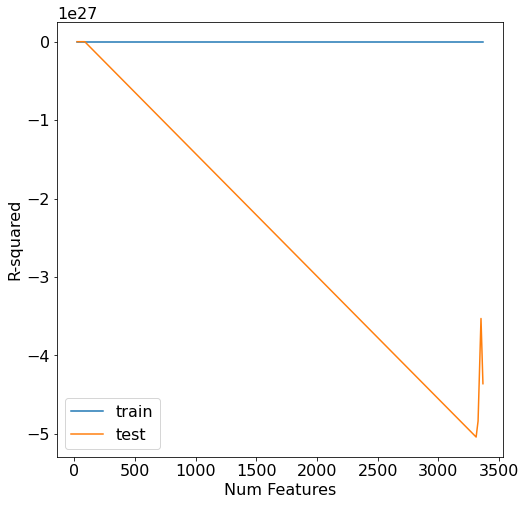

In [18]:
fig = plt.figure();
plt.plot(num_features, train_score_list, label="train");
plt.plot(num_features, test_score_list, label="test");
plt.ylabel("R-squared");
plt.xlabel("Num Features");
plt.legend();

In [19]:
print("Best number of features {} with best test score {} with corresponding train score {}".format(best_X.shape[1], best_test_score, corresponding_train_score))

Best number of features 32 with best test score -0.43090890859659736 with corresponding train score 0.14201240739312337


In [20]:
# Take a look at the best features
best_X.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'is_location_exact', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'instant_bookable', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'num_amenities'],
      dtype='object')

# Conclusion

The results from running linear regression are pretty bad. A lot more can be done to analyze the results. For future work we could try:
* Take a better look at the data 
    * Deal with outliers
    * More thorough cleaning
* Find out which columns are best suited to use 
* Try different models and see the results
* Increase number of data points